In [36]:
%load_ext autoreload
%autoreload 2

In [37]:
# data handling
import geopandas as gpd
import pandas as pd
import numpy as np
import utils

# data analysis
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, f1_score

In [27]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}

# Read csvs
print("--- read .csv files ---")
train_df = gpd.read_file('train.geojson', index_col=0)

test_df = gpd.read_file('test.geojson', index_col=0)

--- read .csv files ---


In [28]:
def handle_na_in_df(df):
    print("number of lines at first:",df.shape[0])
    df_without_na = df.dropna()
    print("number of lines without na:",df_without_na.shape[0])
    indices_without_na = np.asarray(df_without_na.index)
    df_with_na = df[df.isna().any(axis=1)]
    indices_with_na = np.asarray(df_with_na.index)

    indices = np.concatenate([indices_without_na,indices_with_na],axis=0)

    dummy_values = 2*np.ones((indices_with_na.shape[0],))

    return df_without_na,indices,dummy_values


df_without_na,indices,dummy_values = handle_na_in_df(test_df)
print(dummy_values.shape)
print(indices.shape)
print(test_df.shape)

number of lines at first: 120526
number of lines without na: 119176
(1350,)
(120526,)
(120526, 44)


## Plot data features

[0 1 0 ... 4 5 4]
['Construction Done' 'Construction Midway' 'Construction Started'
 'Excavation' 'Greenland' 'Land Cleared' 'Materials Dumped'
 'Materials Introduced' 'Operational' 'Prior Construction' None]
[ 0  1  2  3  4  5  6  7  8  9 10]


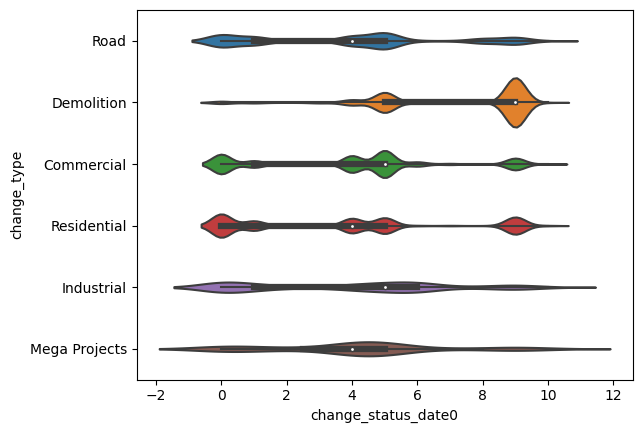

In [29]:
def plot_violin_change_status_date(datei):
    le_plot_change_type = LabelEncoder()
    le_plot_change_status_datei = LabelEncoder()
    le_plot_change_status_datei.fit(np.asarray(train_df[f'change_status_date{datei}']))
    change_status_datei = le_plot_change_status_datei.transform(np.asarray(train_df[f'change_status_date{datei}']))
    print(change_status_datei)
    new_train_df = train_df.copy()
    new_train_df[f'change_status_date{datei}'] = change_status_datei

    sns.violinplot(data=new_train_df, x=f'change_status_date{datei}', y ="change_type")
    print(le_plot_change_status_datei.classes_)
    print(le_plot_change_status_datei.transform(le_plot_change_status_datei.classes_))

plot_violin_change_status_date(0)

[1 1 5 ... 4 5 4]
['Construction Done' 'Construction Midway' 'Construction Started'
 'Excavation' 'Greenland' 'Land Cleared' 'Materials Dumped'
 'Materials Introduced' 'Operational' 'Prior Construction' None]
[ 0  1  2  3  4  5  6  7  8  9 10]


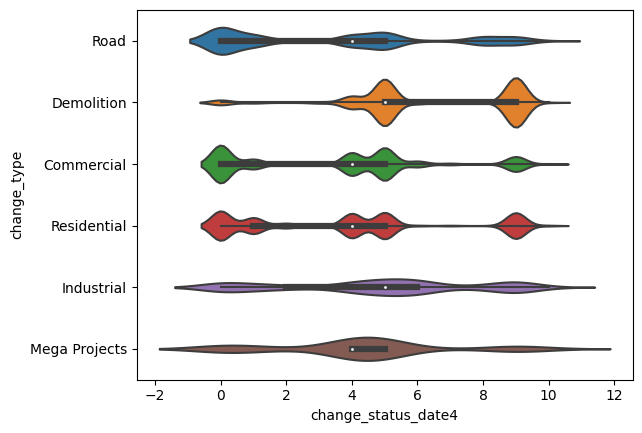

In [30]:
plot_violin_change_status_date(4)

In [31]:
print(train_df.columns)

Index(['urban_type', 'geography_type', 'change_type', 'img_red_mean_date1',
       'img_green_mean_date1', 'img_blue_mean_date1', 'img_red_std_date1',
       'img_green_std_date1', 'img_blue_std_date1', 'img_red_mean_date2',
       'img_green_mean_date2', 'img_blue_mean_date2', 'img_red_std_date2',
       'img_green_std_date2', 'img_blue_std_date2', 'img_red_mean_date3',
       'img_green_mean_date3', 'img_blue_mean_date3', 'img_red_std_date3',
       'img_green_std_date3', 'img_blue_std_date3', 'img_red_mean_date4',
       'img_green_mean_date4', 'img_blue_mean_date4', 'img_red_std_date4',
       'img_green_std_date4', 'img_blue_std_date4', 'img_red_mean_date5',
       'img_green_mean_date5', 'img_blue_mean_date5', 'img_red_std_date5',
       'img_green_std_date5', 'img_blue_std_date5', 'date0',
       'change_status_date0', 'date1', 'change_status_date1', 'date2',
       'change_status_date2', 'date3', 'change_status_date3', 'date4',
       'change_status_date4', 'index', 'geometry']

## Feature engineering

In [32]:
print("--- Feature engineering ---")


def get_features(df):
    dic_features = {"names":[],"features":[]}

    # geometry features
    perimeter = np.asarray(df['geometry'].length)
    perimeter = np.expand_dims(perimeter, axis=-1)
    dic_features["features"].append(perimeter)
    dic_features["names"].append("perimeter")

    area_values = np.asarray(df['geometry'].area)
    area_values = np.expand_dims(area_values, axis=-1)
    dic_features["features"].append(area_values)
    dic_features["names"].append("area")

    ratio_area_over_perimeter = area_values/perimeter
    dic_features["features"].append(ratio_area_over_perimeter)
    dic_features["names"].append("ratio_area_over_perimeter")

    def get_ratio_length_min_max(exte):
        x,y = exte.xy
        lengths = [np.sqrt((x[i]-x[i+1])**2+(y[i]-y[i+1])**2) for i in range(4)]
        return np.min(lengths)/np.max(lengths)
    
    ratio_length_min_max = np.asarray(df['geometry'].exterior.apply([get_ratio_length_min_max]))
    dic_features["features"].append(ratio_length_min_max)
    dic_features["names"].append("ratio_length_min_max")

    centroids = df['geometry'].centroid
    positionx = np.asarray(centroids.x)
    positionx = np.expand_dims(positionx,axis=-1)
    dic_features["features"].append(positionx)
    dic_features["names"].append("positionx")
    positiony = np.asarray(centroids.y)
    positiony = np.expand_dims(positiony,axis=-1)
    dic_features["features"].append(positiony)
    dic_features["names"].append("positiony")

    # diameter
    def get_coords(geom):
        coords = list(geom.exterior.coords)
        return (coords)

    def get_diameters(coord):
        arr_coord = np.array(coord)
        distances = utils.get_distances(arr_coord,arr_coord)
        return np.max(distances)

    coords = df.geometry.apply(get_coords)
    diameters = coords.apply(get_diameters)
    diameters = np.asarray(diameters)
    diameters = np.expand_dims(diameters,axis=-1)
    dic_features["features"].append(diameters)
    dic_features["names"].append("diameters")

    ratio_area_over_diameter = perimeter/diameters
    dic_features["features"].append(ratio_area_over_diameter)
    dic_features["names"].append("ratio_area_over_diameter")

    ratio_perimeter_over_diameter = area_values/diameters
    dic_features["features"].append(ratio_perimeter_over_diameter)
    dic_features["names"].append("ratio_perimeter_over_diameter")

    # geography features
    mlb_urban_type = MultiLabelBinarizer()
    urban_type = np.asarray(df["urban_type"].apply(lambda x: x.split(",") if x!="N,A" else [x]))
    mlb_urban_type.fit(urban_type)
    urban_type = mlb_urban_type.transform(urban_type)
    dic_features["features"].append(urban_type)
    dic_features["names"]+=list(mlb_urban_type.classes_)

    mlb_geography_type = MultiLabelBinarizer()
    geography_type = np.asarray(df["geography_type"].apply(lambda x: x.split(",") if x!="N,A" else [x]))
    mlb_geography_type.fit(geography_type)
    geography_type = mlb_geography_type.transform(geography_type)
    dic_features["features"].append(geography_type)
    dic_features["names"]+=list(mlb_geography_type.classes_)

    # dates/images features
    def get_sorted_date_diff_with_indices(df):
        dates_to_add = []
        for i in range(5):
            date = df[f'date{i}'].apply(lambda x: int(str(x)[-4:]))
            date = np.asarray(date)
            date = np.expand_dims(date,axis=-1)
            dates_to_add.append(date)

        dates = np.concatenate(dates_to_add,axis=-1)

        indices_dates = np.argsort(dates,axis=-1)
        dates = np.array([dates[i,indices_dates[i,:]] for i in range(dates.shape[0])])

        date_diff = dates - dates[:,-1:]@np.ones((1,5),dtype=int)
        return date_diff, indices_dates

    date_diff,indices_dates=get_sorted_date_diff_with_indices(df)
    dic_features["features"].append(date_diff)
    dic_features["names"]+=[f"new_date_diff{i}" for i in range(5)]

    # colors
    trad_colors = {"red":0,"blue":1,"green":2}
    def get_mean_std(df):
        colors = list(trad_colors.keys())
        res = np.zeros((df.shape[0],5,3,2))
        for i in range(1,6):
            for j_color,color in enumerate(colors):
                res[:,i-1,j_color,0] = np.asarray(df[f"img_{color}_mean_date{i}"])
                res[:,i-1,j_color,1] = np.asarray(df[f"img_{color}_std_date{i}"])
        return res

    color_mean_std = get_mean_std(df)
    color_mean_std = np.array([color_mean_std[i,indices_dates[i,:],:,:] for i in range(color_mean_std.shape[0])])

    for i in range(color_mean_std.shape[2]):
        for j in range(color_mean_std.shape[3]):
            dic_features["features"].append(color_mean_std[:,:,i,j])
            dic_features["names"]+=[f"color_mean_std_{date}_{i}_{j}" for date in range(5)]

    # max color mean
    dic_features["features"].append(np.argmax(color_mean_std[:,:,0,:],axis=-1))
    dic_features["names"]+=[f"color_max_mean_{date}_{0}" for date in range(5)]

    # change statuses
    le_change_status = LabelEncoder()
    change_statuses = np.zeros((df.shape[0],5),dtype=int)
    for i in range(5):
        change_status_datei = np.asarray(df[f"change_status_date{i}"])
        le_change_status.fit(change_status_datei)
        change_status_datei = le_change_status.transform(change_status_datei)
        change_statuses[:,i]= change_status_datei
    
    change_statuses =  np.array([change_statuses[i,indices_dates[i,:]] for i in range(change_statuses.shape[0])])
    dic_features["features"].append(change_statuses)
    dic_features["names"]+=[f"change_status_date{i}" for i in range(5) ]


    # final concatenation
    res = np.concatenate(dic_features["features"], axis=-1)

    return res,dic_features


train_df_without_na,train_indices,train_dummy_values = handle_na_in_df(train_df)
train_x,train_dic_features= get_features(train_df_without_na)
utils.display_features(train_dic_features)
train_y = train_df_without_na['change_type'].apply(lambda x: change_type_map[x])

test_df_without_na,test_indices,test_dummy_values = handle_na_in_df(test_df)
test_x,_ = get_features(test_df_without_na)

print("train_x.shape, train_y.shape, test_x.shape :\n",
      train_x.shape, train_y.shape, test_x.shape)


--- Feature engineering ---
number of lines at first: 296146
number of lines without na: 292758


C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeter = np.asarray(df['geometry'].length)
C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_values = np.asarray(df['geometry'].area)
C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df['geometry'].centroid


['perimeter'] (292758, 1)
['area'] (292758, 1)
['ratio_area_over_perimeter'] (292758, 1)
['ratio_length_min_max'] (292758, 1)
['positionx'] (292758, 1)
['positiony'] (292758, 1)
['diameters'] (292758, 1)
['ratio_area_over_diameter'] (292758, 1)
['ratio_perimeter_over_diameter'] (292758, 1)
['Dense Urban', 'Industrial', 'N,A', 'Rural', 'Sparse Urban', 'Urban Slum'] (292758, 6)
['Barren Land', 'Coastal', 'Dense Forest', 'Desert', 'Farms', 'Grass Land', 'Hills', 'Lakes', 'N,A', 'River', 'Snow', 'Sparse Forest'] (292758, 12)
['new_date_diff0', 'new_date_diff1', 'new_date_diff2', 'new_date_diff3', 'new_date_diff4'] (292758, 5)
['color_mean_std_0_0_0', 'color_mean_std_1_0_0', 'color_mean_std_2_0_0', 'color_mean_std_3_0_0', 'color_mean_std_4_0_0'] (292758, 5)
['color_mean_std_0_0_1', 'color_mean_std_1_0_1', 'color_mean_std_2_0_1', 'color_mean_std_3_0_1', 'color_mean_std_4_0_1'] (292758, 5)
['color_mean_std_0_1_0', 'color_mean_std_1_1_0', 'color_mean_std_2_1_0', 'color_mean_std_3_1_0', 'color_

C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeter = np.asarray(df['geometry'].length)
C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_values = np.asarray(df['geometry'].area)
C:\Users\jtros\AppData\Local\Temp\ipykernel_5312\2322207215.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df['geometry'].centroid


train_x.shape, train_y.shape, test_x.shape :
 (292758, 72) (292758,) (119176, 72)


In [57]:
print(train_x[:,3])

[0.34773353 0.52094869 0.29277306 ... 0.5663036  0.89643648 0.53913295]


In [40]:
######## Training ########

print("--- train ---")
rnd_clf = RandomForestClassifier(n_estimators=100,max_depth=50,max_leaf_nodes=45000, bootstrap =True, verbose=True, n_jobs=-1)

# rnd_clf.fit(train_x,train_y)
# pred_y = rnd_clf.predict(train_x)
# print("f1_score on training set :", f1_score(pred_y, train_y,average='macro'))
# utils.plot_and_save_confusion_matrix(pred_y,train_y,dst_path = "./results/confusion_matrix_rnd_clf.png")

# knn_clf = KNeighborsClassifier(n_neighbors=8,n_jobs=-1)
# knn_clf.fit(train_x,train_y)
# pred_y = knn_clf.predict(train_x)
# print("f1_score on training set :", f1_score(pred_y, train_y,average='macro'))
# utils.plot_and_save_confusion_matrix(pred_y,train_y,dst_path = "./results/confusion_matrix_rnd_clf.png")

do_cross_validation = False
if do_cross_validation:
    def display_scores(scores):
        print("Scores:",scores)
        print("Mean",scores.mean())
        print("Std:",scores.std())

    scores = cross_val_score(rnd_clf,train_x,train_y,scoring="f1_macro",cv=3)
    display_scores(scores)



--- train ---
f1_score on training set : 0.4405403439067049


### For hyperparameter optimization

In [42]:

import optuna

def objective(trial):
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 20000, 45000)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    rnd_clf = RandomForestClassifier(n_estimators=n_estimators,max_leaf_nodes=max_leaf_nodes, bootstrap=True, verbose=True, n_jobs=-1)

    scores = cross_val_score(rnd_clf,train_x,train_y,scoring="f1_macro",cv=4)
    return scores.mean()


study = optuna.create_study()
study.optimize(objective, n_trials=100)
best_params = study.best_params
found_max_leaf_nodes = best_params["max_leaf_nodes"]
found_n_estimators = best_params["n_estimators"]


import yaml

with open('hp_optim.yaml', 'w') as outfile:
    yaml.dump({"found_max_leaf_nodes":found_max_leaf_nodes,"found_n_estimators":found_n_estimators}, outfile, default_flow_style=False)


[I 2023-01-14 00:14:59,935] A new study created in memory with name: no-name-6ca38c48-1ae4-4442-aa83-3c3ee10b227b
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.8s


In [ ]:
print(found_n_estimators,found_max_leaf_nodes)

### Find the most promising features

In [61]:
def display_feature_importances(dic_features,clf):
    for i,feat_name in enumerate(dic_features["names"]):
        print(f"{feat_name} importance:",clf.feature_importances_[i]) 

display_feature_importances(train_dic_features,rnd_clf)

print([estimator.get_depth() for estimator in rnd_clf.estimators_])
print([estimator.get_n_leaves() for estimator in rnd_clf.estimators_])

perimeter importance: 0.036616864282719715
area importance: 0.0013899410504910753
ratio_area_over_perimeter importance: 0.020895273954497355
ratio_length_min_max importance: 0.023639947405342844
positionx importance: 0.05517468028101462
positiony importance: 0.0683755851265069
diameters importance: 0.03714099113331725
ratio_area_over_diameter importance: 0.034576477568514535
ratio_perimeter_over_diameter importance: 0.025900266937503722
Dense Urban importance: 0.0030305637469579512
Industrial importance: 0.005555370141872278
N,A importance: 0.001382723658313684
Rural importance: 0.0010927567456874314
Sparse Urban importance: 0.002019025201953335
Urban Slum importance: 0.00047171572616993543
Barren Land importance: 0.0019092288282473347
Coastal importance: 0.0006524434111442805
Dense Forest importance: 0.0022208729745105873
Desert importance: 0.00045868215536031166
Farms importance: 0.002012967975227854
Grass Land importance: 0.002239452099085301
Hills importance: 0.00017686957611917818

## Send predictions

In [19]:
pred_y = rnd_clf.predict(test_x)
print("prediction on test set shape :", pred_y.shape)
print(pred_y)

pred_y = np.concatenate([pred_y,test_dummy_values],axis=0)
print("pred_y.shape after:",pred_y.shape)
print(test_dummy_values.shape)
print(test_indices.shape)
new_test_indices = np.expand_dims(test_indices,axis=-1)
new_pred = np.expand_dims(pred_y,axis=-1)
print(new_pred.shape,new_test_indices.shape)
new_pred_y = np.concatenate([new_test_indices,new_pred],axis=-1)
new_pred_y = new_pred_y[np.argsort(new_pred[:,0],axis=0),1]
new_pred_y = new_pred_y.astype(int)
print(new_pred_y)


######## Save results to submission file ########
print("--- save ---")
pred_df = pd.DataFrame(new_pred_y, columns=['change_type'])
pred_df.to_csv("my_submission.csv", index=True, index_label='Id')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    2.2s


prediction on test set shape : (119176,)
[3 2 2 ... 3 3 3]
pred_y.shape after: (120526,)
(1350,)
(120526,)
(120526, 1) (120526, 1)
[0 0 0 ... 5 5 5]
--- save ---


[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    2.7s finished
